In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from torchvision.transforms import ToTensor

In [2]:
# Define dataset path
dataset_path = "./datacollect/Nishtha.npy"

# Create dataset directory if it doesn't exist
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Define labels (example, replace with actual labels)
labels = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

class CustomDataset(Dataset):
    def __init__(self, data_path, labels):
        self.data = np.load(data_path)
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        # Normalize and reshape the image for PyTorch
        img = img / 255.0  # Normalize to [0, 1]
        img = np.expand_dims(img, axis=0)  # Add channel dimension for grayscale image
        
        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

class FaceCNN(nn.Module):
    def __init__(self):
        super(FaceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.fc2 = nn.Linear(128, 2)  # Adjust output size according to the number of classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 25 * 25)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate dataset and dataloader
dataset = CustomDataset(dataset_path, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
model = FaceCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model
torch.save(model.state_dict(), "face_cnn.pth")
print("Model trained and saved as face_cnn.pth")


Epoch [1/10], Loss: 4.5938
Epoch [2/10], Loss: 0.8796
Epoch [3/10], Loss: 0.7514
Epoch [4/10], Loss: 0.6944
Epoch [5/10], Loss: 0.5754
Epoch [6/10], Loss: 0.8434
Epoch [7/10], Loss: 0.7932
Epoch [8/10], Loss: 0.6590
Epoch [9/10], Loss: 0.7296
Epoch [10/10], Loss: 0.6902
Model trained and saved as face_cnn.pth


In [3]:
data_path = "./datacollect/Nishtha.npy"

# Check if the file exists
if not os.path.exists(data_path):
    print(f"Error: File '{data_path}' does not exist.")
    # Exit or handle the error as needed
    exit(1)

# Check if the file is accessible
if not os.access(data_path, os.R_OK):
    print(f"Error: Cannot read file '{data_path}'. Check file permissions.")
    # Exit or handle the error as needed
    exit(1)

# Load the data
try:
    data = np.load(data_path)
    print("Data loaded successfully!")
    # Continue processing your data
except Exception as e:
    print(f"Error loading data: {e}")


Data loaded successfully!


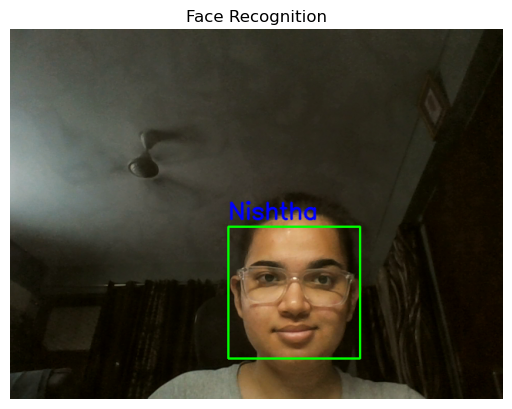

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [7]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FaceCNN().to(device)
model.load_state_dict(torch.load("face_cnn.pth"))
model.eval()

# Load face data
dataset_path = "./datacollect/"
label_map = {}
class_id = 0
for f in os.listdir(dataset_path):
    if f.endswith(".npy"):
        label_map[class_id] = f[:-4]
        class_id += 1

# Face detection using OpenCV and Haar Cascade
cam = cv2.VideoCapture(0)
model_cascade = cv2.CascadeClassifier("C:\\Users\\Nishtha\\Downloads\\haarcascade_frontalface_alt.xml")

while True:
    success, img = cam.read()
    if not success:
        print("Reading camera failed!")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = model_cascade.detectMultiScale(gray, 1.3, 5)
    
    for x, y, w, h in faces:
        face_img = gray[y:y + h, x:x + w]
        face_img = cv2.resize(face_img, (100, 100))
        face_img = face_img / 255.0  # Normalize
        face_img = np.expand_dims(face_img, axis=0)
        face_img = np.expand_dims(face_img, axis=0)
        face_tensor = torch.tensor(face_img, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            output = model(face_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_class = predicted.item()
            
            if predicted_class in label_map:
                label = label_map[predicted_class]
            else:
                label = "Unknown"
        
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display using matplotlib as an alternative
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Face Recognition")
    plt.axis("off")
    plt.show()
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()


In [ ]:
cam.release()
cv2.destroyAllWindows()